In [7]:
import pandas as pd
import numpy as np
import torch
from sklearn.preprocessing import LabelEncoder
from torch_geometric.data import Data

# load the preprocessed datasets
players_data = pd.read_csv('players_features.csv')
teams_data = pd.read_csv('teams_features.csv')

# 首先检查数据框的列名
print("Players data columns:", players_data.columns.tolist())
print("Teams data columns:", teams_data.columns.tolist())

# encode the positions as integers
position_encoder = LabelEncoder()
nation_encoder = LabelEncoder()
players_data['Pos'] = position_encoder.fit_transform(players_data['Pos'])
players_data['Nation'] = nation_encoder.fit_transform(players_data['Nation'])

player_nodes = {}
team_nodes = {}
player_to_team_edges = []
player_to_player_edges = []

# extract player nodes, and name them "player_year"
for _, row in players_data.iterrows():
    player_key = f"{row['Player']}_{row['Year']}"
    player_nodes[player_key] = {
        'Born': row['Born'],
        'Pos': row['Pos'],  # Encoded as integer
        'Market_Value_Euro': row['market_value_euro'],
        'Nation': row['Nation'],
    }

# extract team nodes, and name them "team_year"
for _, row in teams_data.iterrows():
    # 查找正确的球队列名
    team_col = None
    for col in ['Squad', 'Team', 'Club']:
        if col in teams_data.columns:
            team_col = col
            break
    if team_col is None:
        team_col = teams_data.columns[1]  # 假设第二个列是球队名
    
    team_key = f"{row[team_col]}_{row['Year']}"
    team_nodes[team_key] = {key: row[key] for key in teams_data.columns if key not in ['Year', team_col]}

print(f"Found {len(player_nodes)} player nodes and {len(team_nodes)} team nodes")

# create the player-to-team edges
for _, row in players_data.iterrows():
    player_key = f"{row['Player']}_{row['Year']}"
    
    # 查找球员数据中的球队列名
    team_col_in_players = None
    for col in ['Squad', 'Team', 'Club']:
        if col in players_data.columns:
            team_col_in_players = col
            break
    
    if team_col_in_players is None:
        team_col_in_players = players_data.columns[1]
    
    team_key = f"{row[team_col_in_players]}_{row['Year']}"
    
    if player_key in player_nodes and team_key in team_nodes:
        edge_features = {key: row[key] for key in [
            'Gls', 'Ast', 'G_plus_A', 'G_minus_PK', 'PK', 'PKatt',
            'CrdY', 'CrdR', 'xG_Expected', 'npxG_Expected', 'xAG_Expected',
            'npxG_plus_xAG_Expected', 'PrgC_Progression', 'PrgP_Progression',
            'Gls_Per_90', 'Ast_Per_90', 'G_plus_A_Per_90', 'G_minus_PK_Per_90',
            'G_plus_A_minus_PK_Per_90', 'xG_Per_90', 'xAG_Per_90',
            'xG_plus_xAG_Per_90', 'npxG_Per_90', 'npxG_plus_xAG_Per_90',
            'Gls_mean','Gls_std','Gls_max','Gls_sum','Ast_mean','Ast_std',
            'Ast_max','Ast_sum','xG_Expected_mean','xG_Expected_std',
            'xG_Expected_max','xG_Expected_sum','xAG_Expected_mean',
            'xAG_Expected_std','xAG_Expected_max','xAG_Expected_sum',
            'market_value_euro_mean','market_value_euro_std','market_value_euro_max',
            'market_value_euro_sum','attack_core_ratio','eng_player_ratio'
        ] if key in players_data.columns}  # 只包含存在的列
        player_to_team_edges.append((player_key, team_key, edge_features))

print(f"Created {len(player_to_team_edges)} player-to-team edges")

# create the player-to-player edges
player_grouped = players_data.groupby('Player')
for player, group in player_grouped:
    group_sorted = group.sort_values(by='Year')
    for i in range(len(group_sorted) - 1):
        curr_row = group_sorted.iloc[i]
        next_row = group_sorted.iloc[i + 1]

        curr_player_key = f"{curr_row['Player']}_{curr_row['Year']}"
        next_player_key = f"{next_row['Player']}_{next_row['Year']}"

        if curr_player_key in player_nodes and next_player_key in player_nodes:
            edge_features = {}
            
            # 安全地构建特征字典，只处理数值类型
            feature_keys = [
                'Gls', 'Ast', 'G_plus_A', 'G_minus_PK', 'PK', 'PKatt',
                'CrdY', 'CrdR', 'xG_Expected', 'npxG_Expected', 'xAG_Expected',
                'npxG_plus_xAG_Expected', 'PrgC_Progression', 'PrgP_Progression',
                'Gls_Per_90', 'Ast_Per_90', 'G_plus_A_Per_90', 'G_minus_PK_Per_90',
                'G_plus_A_minus_PK_Per_90', 'xG_Per_90', 'xAG_Per_90',
                'xG_plus_xAG_Per_90', 'npxG_Per_90', 'npxG_plus_xAG_Per_90',     
                'is_eng','is_big6_team','goal_contrib',
                'xG_contrib','is_attack_core','age_x_market_value','log_market_value',
                'goal_per90','assist_per90','xG_per90','xAG_per90','Gls_to_team_mean',
                'Ast_to_team_mean','xG_Expected_to_team_mean','xAG_Expected_to_team_mean'
            ]
            
            for key in feature_keys:
                if key in players_data.columns:
                    try:
                        # 转换为数值类型
                        curr_val = pd.to_numeric(curr_row[key], errors='coerce')
                        next_val = pd.to_numeric(next_row[key], errors='coerce')
                        
                        # 如果转换成功且不是NaN，则计算差值
                        if not pd.isna(curr_val) and not pd.isna(next_val):
                            edge_features[key] = float(next_val - curr_val)
                    except (ValueError, TypeError):
                        # 如果转换失败，跳过这个特征
                        continue
            
            if edge_features:  # 只有当有有效特征时才添加边
                player_to_player_edges.append((curr_player_key, next_player_key, edge_features))

print(f"Created {len(player_to_player_edges)} player-to-player edges")

# === 关键修改：统一边特征维度 ===
print("\n=== 统一边特征维度 ===")

# 收集所有可能的特征键
all_feature_keys = set()

# 从球员-球队边收集特征键
for player_key, team_key, features in player_to_team_edges:
    all_feature_keys.update(features.keys())

# 从球员-球员边收集特征键
for curr_player_key, next_player_key, features in player_to_player_edges:
    all_feature_keys.update(features.keys())

all_feature_keys = sorted(list(all_feature_keys))
print(f"所有特征键数量: {len(all_feature_keys)}")
print(f"特征键列表: {all_feature_keys}")

# 重新构建边特征，确保维度一致
unified_team_edges = []
unified_player_edges = []

# 统一球员-球队边
for player_key, team_key, features in player_to_team_edges:
    unified_features = []
    for key in all_feature_keys:
        unified_features.append(features.get(key, 0.0))  # 缺失特征用0填充
    unified_team_edges.append((player_key, team_key, unified_features))

# 统一球员-球员边
for curr_player_key, next_player_key, features in player_to_player_edges:
    unified_features = []
    for key in all_feature_keys:
        unified_features.append(features.get(key, 0.0))  # 缺失特征用0填充
    unified_player_edges.append((curr_player_key, next_player_key, unified_features))

print(f"统一后特征维度: {len(all_feature_keys)}")
print(f"球队边数量: {len(unified_team_edges)}")
print(f"球员边数量: {len(unified_player_edges)}")

# assign unique IDs to nodes
all_nodes = list(player_nodes.keys()) + list(team_nodes.keys())
node_to_id = {node: i for i, node in enumerate(all_nodes)}

edge_index = []
edge_attr = []

# add the player-to-team edges (使用统一后的边)
for player_key, team_key, features in unified_team_edges:
    if player_key in node_to_id and team_key in node_to_id:
        edge_index.append([node_to_id[player_key], node_to_id[team_key]])
        edge_attr.append(features)

# add the player-to-player edges (使用统一后的边)
for curr_player_key, next_player_key, features in unified_player_edges:
    if curr_player_key in node_to_id and next_player_key in node_to_id:
        edge_index.append([node_to_id[curr_player_key], node_to_id[next_player_key]])
        edge_attr.append(features)

print(f"Total edges: {len(edge_index)}")
print(f"Final edge feature dimension: {len(edge_attr[0]) if edge_attr else 0}")

# convert to PyTorch Geometric tensors
if edge_index:
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    edge_attr = torch.tensor(edge_attr, dtype=torch.float)
else:
    edge_index = torch.tensor([[], []], dtype=torch.long)
    edge_attr = torch.tensor([], dtype=torch.float)

# 关键修复：正确计算特征维度
# 获取团队节点的特征维度
if team_nodes:
    sample_team_key = next(iter(team_nodes.keys()))
    team_feature_dim = len(team_nodes[sample_team_key])
else:
    team_feature_dim = 0

print(f"Player feature dim: 4 (Born, Market_Value_Euro, Pos, Nation)")
print(f"Team feature dim: {team_feature_dim}")

# combine all features for nodes
all_features = []
for node in node_to_id.keys():
    if node in player_nodes:
        player_features = player_nodes[node]
        # 球员节点: [Born, Market_Value_Euro, Pos, Nation] + 团队特征维度的零填充
        player_feature = [
            player_features['Born'],
            player_features['Market_Value_Euro'],
            player_features['Pos'],
            player_features['Nation']
        ]
        # 用零填充到与团队节点相同的总维度
        padding = [0] * team_feature_dim
        all_features.append(player_feature + padding)
        
    elif node in team_nodes:
        team_features = team_nodes[node]
        # 团队节点: 4个零填充 + 团队特征
        padding = [0, 0, 0, 0]  # 对应球员的4个特征
        team_feature = list(team_features.values())
        all_features.append(padding + team_feature)

node_features = torch.tensor(all_features, dtype=torch.float)

# create PyTorch Geometric Data object
data = Data(x=node_features, edge_index=edge_index, edge_attr=edge_attr)

print("\n=== 图构建完成 ===")
print("Graph created successfully!")
print(f"Number of nodes: {data.num_nodes}")
print(f"Number of edges: {data.num_edges}")
print(f"Node feature shape: {data.x.shape}")
print(f"Edge feature shape: {data.edge_attr.shape}")

# 验证特征维度一致性
if team_nodes:
    # 检查球员节点和团队节点的特征维度是否一致
    player_node_idx = 0  # 第一个节点应该是球员
    team_node_idx = len(player_nodes)  # 第一个团队节点
    
    print(f"First player node features shape: {data.x[player_node_idx].shape}")
    print(f"First team node features shape: {data.x[team_node_idx].shape}")
    
    if data.x[player_node_idx].shape == data.x[team_node_idx].shape:
        print("✓ Node feature dimensions are consistent!")
    else:
        print("✗ Node feature dimensions are inconsistent!")

# 保存特征映射，便于后续分析
feature_mapping = {i: key for i, key in enumerate(all_feature_keys)}
print(f"\n=== 特征映射信息 ===")
print(f"总特征数量: {len(feature_mapping)}")
print("前10个特征映射:")
for i in range(min(10, len(feature_mapping))):
    print(f"  {i}: {feature_mapping[i]}")

# 可选：保存特征映射到文件
import json
with open('feature_mapping.json', 'w') as f:
    json.dump(feature_mapping, f, indent=2)
print("特征映射已保存到 'feature_mapping.json'")

# 可选：显示不同类型边的特征统计
if len(unified_team_edges) > 0 and len(unified_player_edges) > 0:
    print(f"\n=== 边特征统计 ===")
    
    # 计算球队边的非零特征比例
    team_non_zero = 0
    team_total = len(unified_team_edges) * len(all_feature_keys)
    for _, _, features in unified_team_edges:
        team_non_zero += sum(1 for f in features if f != 0)
    
    # 计算球员边的非零特征比例
    player_non_zero = 0
    player_total = len(unified_player_edges) * len(all_feature_keys)
    for _, _, features in unified_player_edges:
        player_non_zero += sum(1 for f in features if f != 0)
    
    print(f"球队边非零特征比例: {team_non_zero/team_total:.2%}")
    print(f"球员边非零特征比例: {player_non_zero/player_total:.2%}")

Players data columns: ['Season_End_Year', 'Player', 'Nation', 'Pos', 'Age', 'Born', 'MP_Playing', 'Starts_Playing', 'Min_Playing', 'Mins_Per_90_Playing', 'Gls', 'Ast', 'G_plus_A', 'G_minus_PK', 'PK', 'PKatt', 'CrdY', 'CrdR', 'PrgC_Progression', 'PrgP_Progression', 'PrgR_Progression', 'Gls_Per_90', 'Ast_Per_90', 'G_plus_A_Per_90', 'G_minus_PK_Per_90', 'G_plus_A_minus_PK_Per_90', 'xG_Expected', 'npxG_Expected', 'xAG_Expected', 'npxG_plus_xAG_Expected', 'xG_Per_90', 'xAG_Per_90', 'xG_plus_xAG_Per_90', 'npxG_Per_90', 'npxG_plus_xAG_Per_90', 'Year', 'market_value_euro', 'Squad', 'is_eng', 'is_big6_team', 'age_group', 'goal_contrib', 'xG_contrib', 'is_attack_core', 'age_x_market_value', 'log_market_value', 'goal_per90', 'assist_per90', 'xG_per90', 'xAG_per90', 'Gls_to_team_mean', 'Ast_to_team_mean', 'xG_Expected_to_team_mean', 'xAG_Expected_to_team_mean']
Teams data columns: ['Year', 'Squad', 'Age', 'Poss', 'MP_Playing', 'Starts_Playing', 'Min_Playing', 'Mins_Per_90_Playing', 'Gls', 'Ast', '

Preprocessing data...
Player nodes: 1775, Team nodes: 120
Training players: 1056
Validation players: 355
Test players: 364
Starting training...
Epoch: 010, Train Loss: 8.83%, Val Loss: 3.77%, LR: 0.001000
Epoch: 020, Train Loss: 5.63%, Val Loss: 2.45%, LR: 0.001000
Epoch: 030, Train Loss: 4.27%, Val Loss: 2.31%, LR: 0.001000
Epoch: 040, Train Loss: 3.22%, Val Loss: 1.83%, LR: 0.001000
Epoch: 050, Train Loss: 2.38%, Val Loss: 1.06%, LR: 0.001000
Epoch: 060, Train Loss: 1.59%, Val Loss: 0.85%, LR: 0.001000
Epoch: 070, Train Loss: 1.16%, Val Loss: 0.68%, LR: 0.001000
Epoch: 080, Train Loss: 0.95%, Val Loss: 0.69%, LR: 0.001000
Epoch: 090, Train Loss: 0.80%, Val Loss: 0.63%, LR: 0.001000
Epoch: 100, Train Loss: 0.77%, Val Loss: 0.52%, LR: 0.001000
Epoch: 110, Train Loss: 0.69%, Val Loss: 0.37%, LR: 0.000500
Epoch: 120, Train Loss: 0.66%, Val Loss: 0.46%, LR: 0.000500
Epoch: 130, Train Loss: 0.62%, Val Loss: 0.48%, LR: 0.000250
Epoch: 140, Train Loss: 0.61%, Val Loss: 0.44%, LR: 0.000250
Ep

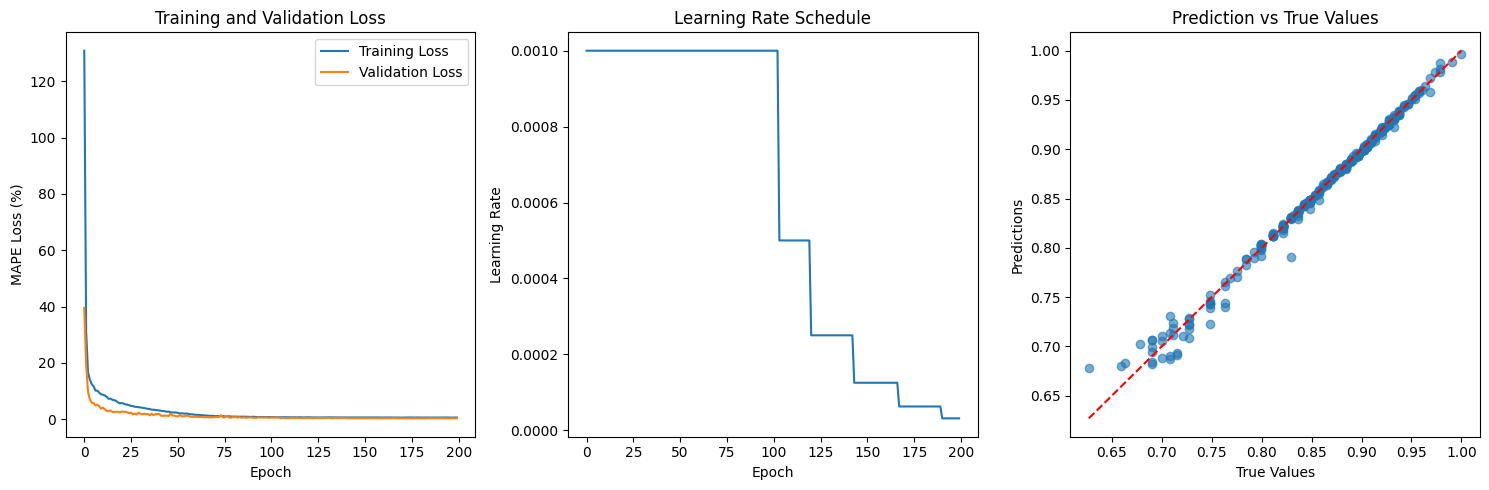

In [8]:
import pandas as pd
import torch
from torch_geometric.nn import SAGEConv
from torch_geometric.loader import NeighborLoader
import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

# Set random seed
SEED = 42
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

# Define the GraphSAGE model
class GraphSAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.2):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, out_channels)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.dropout(x)

        x = self.conv2(x, edge_index)
        x = F.relu(x)  # Ensure non-negative outputs for market value

        return x

# Enhanced GraphSAGE with more layers
class DeepGraphSAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers=3, dropout=0.2):
        super(DeepGraphSAGE, self).__init__()
        self.convs = torch.nn.ModuleList()
        self.convs.append(SAGEConv(in_channels, hidden_channels))
        
        for _ in range(num_layers - 2):
            self.convs.append(SAGEConv(hidden_channels, hidden_channels))
            
        self.convs.append(SAGEConv(hidden_channels, out_channels))
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x, edge_index):
        for i in range(len(self.convs) - 1):
            x = self.convs[i](x, edge_index)
            x = F.relu(x)
            x = self.dropout(x)
        
        x = self.convs[-1](x, edge_index)
        x = F.relu(x)
        return x

# 1. Data preprocessing with robust normalization
print("Preprocessing data...")

# Handle NaN and Inf values
data.x[torch.isnan(data.x)] = 0
data.x[torch.isinf(data.x)] = 0

# Robust normalization (better for outliers)
def robust_normalize(tensor):
    median = torch.median(tensor, dim=0).values
    q75 = torch.quantile(tensor, 0.75, dim=0)
    q25 = torch.quantile(tensor, 0.25, dim=0)
    iqr = q75 - q25
    iqr = torch.where(iqr == 0, torch.ones_like(iqr), iqr)
    return (tensor - median) / iqr

data.x = robust_normalize(data.x)

# 2. Set up target variable - ONLY for player nodes
data.y = torch.zeros(data.x.size(0), dtype=torch.float32)

# Create player node mask for later use
player_node_mask = torch.zeros(data.x.size(0), dtype=torch.bool)
for node_name, node_id in node_to_id.items():
    if node_name in player_nodes:
        player_node_mask[node_id] = True
        if 'Market_Value_Euro' in player_nodes[node_name]:
            market_value = player_nodes[node_name]['Market_Value_Euro']
            if market_value > 0:
                data.y[node_id] = market_value

print(f"Player nodes: {player_node_mask.sum()}, Team nodes: {(~player_node_mask).sum()}")

# 3. Enhanced target scaling with log transformation
# Market values often follow log-normal distribution
positive_mask = data.y > 0
if positive_mask.sum() > 0:
    data.y[positive_mask] = torch.log1p(data.y[positive_mask])  # log(1 + y)
    data.y_max = data.y[positive_mask].max()
    data.y[positive_mask] = data.y[positive_mask] / data.y_max

# 4. Create temporal masks - ONLY for player nodes
val_year = 2023
test_year = 2024
data.train_mask = torch.zeros(data.x.size(0), dtype=torch.bool)
data.val_mask = torch.zeros(data.x.size(0), dtype=torch.bool)
data.test_mask = torch.zeros(data.x.size(0), dtype=torch.bool)

for node_name, node_id in node_to_id.items():
    if node_name in player_nodes and 'Market_Value_Euro' in player_nodes[node_name]:
        year = int(node_name.split("_")[-1])
        if year < val_year:
            data.train_mask[node_id] = True
        elif year == val_year:
            data.val_mask[node_id] = True
        elif year == test_year:
            data.test_mask[node_id] = True

print(f"Training players: {data.train_mask.sum()}")
print(f"Validation players: {data.val_mask.sum()}")
print(f"Test players: {data.test_mask.sum()}")

# 5. Enhanced NeighborLoader with filtering
def create_player_focused_loaders(data, player_node_mask, batch_size=32):
    """Create data loaders that focus on player nodes"""
    
    # Only sample from player nodes for training/validation/testing
    train_player_mask = data.train_mask & player_node_mask
    val_player_mask = data.val_mask & player_node_mask
    test_player_mask = data.test_mask & player_node_mask
    
    train_loader = NeighborLoader(
        data,
        num_neighbors=[15, 10],  # Increased sampling for better context
        batch_size=batch_size,
        input_nodes=train_player_mask,
        shuffle=True,
        drop_last=True
    )

    val_loader = NeighborLoader(
        data,
        num_neighbors=[15, 10],
        batch_size=batch_size,
        input_nodes=val_player_mask,
        shuffle=False
    )

    test_loader = NeighborLoader(
        data,
        num_neighbors=[15, 10],
        batch_size=batch_size,
        input_nodes=test_player_mask,
        shuffle=False
    )
    
    return train_loader, val_loader, test_loader

train_loader, val_loader, test_loader = create_player_focused_loaders(data, player_node_mask, batch_size=32)

# 6. Enhanced loss functions
def mean_absolute_percentage_error(y_true, y_pred, epsilon=1e-7):
    return torch.mean(torch.abs((y_true - y_pred) / (y_true + epsilon))) * 100

def symmetric_mape(y_true, y_pred, epsilon=1e-7):
    return torch.mean(2 * torch.abs(y_true - y_pred) / (torch.abs(y_true) + torch.abs(y_pred) + epsilon)) * 100

# 7. Initialize model with enhanced configuration
model = GraphSAGE(
    in_channels=data.x.size(1), 
    hidden_channels=128,  # Increased capacity
    out_channels=1, 
    dropout=0.2
)

# Alternative: Use deeper model
# model = DeepGraphSAGE(
#     in_channels=data.x.size(1),
#     hidden_channels=128,
#     out_channels=1,
#     num_layers=3,
#     dropout=0.2
# )

optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=10, factor=0.5)

# 8. Weight initialization
def init_weights(m):
    if isinstance(m, SAGEConv):
        torch.nn.init.xavier_uniform_(m.lin_l.weight)
        torch.nn.init.xavier_uniform_(m.lin_r.weight)
        if m.lin_l.bias is not None:
            torch.nn.init.zeros_(m.lin_l.bias)
        if m.lin_r.bias is not None:
            torch.nn.init.zeros_(m.lin_r.bias)

model.apply(init_weights)

# Training metrics
train_losses = []
val_losses = []
learning_rates = []

# 9. Enhanced training loop
def train():
    model.train()
    total_loss = 0
    batch_count = 0
    
    for batch in train_loader:
        optimizer.zero_grad()
        out = model(batch.x, batch.edge_index).squeeze()
        
        # Only compute loss on player nodes in the training set
        player_train_mask = batch.train_mask & player_node_mask[batch.n_id]
        
        if player_train_mask.sum() > 0:  # Only proceed if there are player nodes
            loss = symmetric_mape(out[player_train_mask], batch.y[player_train_mask])
            loss.backward()
            
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            total_loss += loss.item()
            batch_count += 1
    
    return total_loss / batch_count if batch_count > 0 else 0

def validate():
    model.eval()
    total_loss = 0
    batch_count = 0
    
    with torch.no_grad():
        for batch in val_loader:
            out = model(batch.x, batch.edge_index).squeeze()
            player_val_mask = batch.val_mask & player_node_mask[batch.n_id]
            
            if player_val_mask.sum() > 0:
                val_loss = symmetric_mape(out[player_val_mask], batch.y[player_val_mask])
                total_loss += val_loss.item()
                batch_count += 1
    
    return total_loss / batch_count if batch_count > 0 else float('inf')

def test():
    model.eval()
    total_loss = 0
    all_preds = []
    all_targets = []
    batch_count = 0
    
    with torch.no_grad():
        for batch in test_loader:
            out = model(batch.x, batch.edge_index).squeeze()
            player_test_mask = batch.test_mask & player_node_mask[batch.n_id]
            
            if player_test_mask.sum() > 0:
                test_loss = symmetric_mape(out[player_test_mask], batch.y[player_test_mask])
                total_loss += test_loss.item()
                batch_count += 1
                
                # Collect predictions and targets
                all_preds.append(out[player_test_mask].detach().cpu())
                all_targets.append(batch.y[player_test_mask].detach().cpu())
    
    avg_loss = total_loss / batch_count if batch_count > 0 else float('inf')
    predictions = torch.cat(all_preds, dim=0) if all_preds else torch.tensor([])
    targets = torch.cat(all_targets, dim=0) if all_targets else torch.tensor([])
    
    return avg_loss, predictions, targets

# 10. Training with early stopping
print("Starting training...")
best_val_loss = float('inf')
patience = 20
patience_counter = 0

for epoch in range(1, 201):
    train_loss = train()
    val_loss = validate()
    
    # Learning rate scheduling
    scheduler.step(val_loss)
    current_lr = optimizer.param_groups[0]['lr']
    learning_rates.append(current_lr)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    if epoch % 10 == 0:
        print(f'Epoch: {epoch:03d}, Train Loss: {train_loss:.2f}%, Val Loss: {val_loss:.2f}%, LR: {current_lr:.6f}')
    
    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        # Save best model
        torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': val_loss,
            'epoch': epoch
        }, 'best_graphsage_model.pth')
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f'Early stopping at epoch {epoch}')
            break

# Load best model for testing
checkpoint = torch.load('best_graphsage_model.pth')
model.load_state_dict(checkpoint['model_state_dict'])

# Final test
test_loss, test_predictions, test_targets = test()
print(f'Final Test MAPE: {test_loss:.2f}%')

# 11. Visualization
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MAPE Loss (%)')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(learning_rates)
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.title('Learning Rate Schedule')

plt.subplot(1, 3, 3)
if len(test_predictions) > 0 and len(test_targets) > 0:
    plt.scatter(test_targets, test_predictions, alpha=0.6)
    plt.plot([test_targets.min(), test_targets.max()], [test_targets.min(), test_targets.max()], 'r--')
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.title('Prediction vs True Values')

plt.tight_layout()
plt.show()

In [9]:
import pandas as pd
import numpy as np
import torch
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def predict_player_value(model, player_name, year, data, node_to_id, player_nodes, data_y_max):
    """
    预测单个球员的市场价值
    """
    model.eval()
    
    # 构建球员节点标识
    player_key = f"{player_name}_{year}"
    
    if player_key not in node_to_id:
        print(f"警告: 未找到球员 {player_name} 在 {year} 年的数据")
        return None, None
    
    node_id = node_to_id[player_key]
    
    # 创建包含该节点的数据加载器
    pred_loader = NeighborLoader(
        data,
        num_neighbors=[15, 10],
        batch_size=1,
        input_nodes=torch.tensor([node_id])
    )
    
    with torch.no_grad():
        for batch in pred_loader:
            out = model(batch.x, batch.edge_index).squeeze()
            
            # 找到目标节点在batch中的位置
            batch_node_ids = batch.n_id
            target_idx = (batch_node_ids == node_id).nonzero(as_tuple=True)[0]
            
            if len(target_idx) > 0:
                predicted_value_normalized = out[target_idx[0]].item()
                
                # 反归一化：还原到原始市场价值
                predicted_log_value = predicted_value_normalized * data_y_max
                predicted_value = torch.expm1(torch.tensor(predicted_log_value)).item()
                
                # 获取真实值（如果存在）
                true_value = player_nodes[player_key]['Market_Value_Euro'] if 'Market_Value_Euro' in player_nodes[player_key] else None
                
                return predicted_value, true_value
    
    return None, None

def predict_all_players(model, data, node_to_id, player_nodes, data_y_max, target_year=2024):
    """
    批量预测所有球员在目标年份的市场价值
    """
    model.eval()
    predictions = {}
    
    # 收集所有需要预测的球员节点
    target_nodes = []
    player_info = {}
    
    for node_name, node_id in node_to_id.items():
        if node_name in player_nodes and node_name.endswith(f"_{target_year}"):
            player_name = node_name.replace(f"_{target_year}", "")
            target_nodes.append(node_id)
            player_info[node_id] = (player_name, node_name)
    
    if not target_nodes:
        print(f"没有找到 {target_year} 年的球员数据")
        return predictions
    
    print(f"开始预测 {len(target_nodes)} 名球员在 {target_year} 年的市场价值...")
    
    # 批量预测
    pred_loader = NeighborLoader(
        data,
        num_neighbors=[15, 10],
        batch_size=32,
        input_nodes=torch.tensor(target_nodes)
    )
    
    with torch.no_grad():
        for batch_idx, batch in enumerate(pred_loader):
            out = model(batch.x, batch.edge_index).squeeze()
            batch_node_ids = batch.n_id
            
            for i, node_id in enumerate(batch_node_ids):
                node_id_item = node_id.item()
                if node_id_item in player_info:
                    player_name, node_name = player_info[node_id_item]
                    
                    # 获取预测值
                    predicted_value_normalized = out[i].item()
                    predicted_log_value = predicted_value_normalized * data_y_max
                    predicted_value = torch.expm1(torch.tensor(predicted_log_value)).item()
                    
                    # 获取真实值
                    true_value = player_nodes[node_name]['Market_Value_Euro'] if 'Market_Value_Euro' in player_nodes[node_name] else None
                    
                    predictions[player_name] = {
                        'predicted_value': predicted_value,
                        'true_value': true_value,
                        'year': target_year,
                        'node_id': node_id_item
                    }
            
            if (batch_idx + 1) % 10 == 0:
                print(f"已处理 {batch_idx + 1} 个批次...")
    
    return predictions

def evaluate_predictions(predictions_dict):
    """
    评估预测结果的准确性
    """
    # 提取有真实值的预测结果
    valid_predictions = {k: v for k, v in predictions_dict.items() if v['true_value'] is not None and v['true_value'] > 0}
    
    if not valid_predictions:
        print("没有找到有效的真实值进行评估")
        return {}
    
    true_values = [v['true_value'] for v in valid_predictions.values()]
    pred_values = [v['predicted_value'] for v in valid_predictions.values()]
    
    # 计算评估指标
    mae = mean_absolute_error(true_values, pred_values)
    rmse = np.sqrt(mean_squared_error(true_values, pred_values))
    r2 = r2_score(true_values, pred_values)
    mape = np.mean(np.abs((np.array(true_values) - np.array(pred_values)) / np.array(true_values))) * 100
    
    # 计算平均误差百分比
    errors = [(pred - true) / true * 100 for true, pred in zip(true_values, pred_values)]
    mean_error_percent = np.mean(errors)
    std_error_percent = np.std(errors)
    
    evaluation_metrics = {
        'MAE': mae,
        'RMSE': rmse,
        'R2_Score': r2,
        'MAPE': mape,
        'Mean_Error_Percent': mean_error_percent,
        'Std_Error_Percent': std_error_percent,
        'Number_of_Players': len(valid_predictions)
    }
    
    return evaluation_metrics, valid_predictions

def save_predictions_to_csv(predictions_dict, evaluation_metrics=None, filename="player_value_predictions.csv"):
    """
    将预测结果保存到CSV文件
    """
    # 准备数据
    rows = []
    for player_name, data in predictions_dict.items():
        row = {
            'Player': player_name,
            'Year': data['year'],
            'Predicted_Value_Euro': data['predicted_value'],
            'True_Value_Euro': data['true_value'] if data['true_value'] is not None else 'N/A',
            'Node_ID': data['node_id']
        }
        
        # 计算误差（如果有真实值）
        if data['true_value'] is not None and data['true_value'] > 0:
            error = data['predicted_value'] - data['true_value']
            error_percent = (error / data['true_value']) * 100
            row['Error_Euro'] = error
            row['Error_Percent'] = error_percent
        else:
            row['Error_Euro'] = 'N/A'
            row['Error_Percent'] = 'N/A'
        
        rows.append(row)
    
    # 创建DataFrame
    df = pd.DataFrame(rows)
    
    # 保存到CSV
    df.to_csv(filename, index=False, encoding='utf-8')
    
    print(f"预测结果已保存到 {filename}")
    print(f"总共预测了 {len(predictions_dict)} 名球员")
    
    # 如果有评估指标，也保存到另一个文件
    if evaluation_metrics:
        eval_df = pd.DataFrame([evaluation_metrics])
        eval_filename = filename.replace('.csv', '_evaluation.csv')
        eval_df.to_csv(eval_filename, index=False)
        print(f"评估指标已保存到 {eval_filename}")
    
    return df

def save_detailed_analysis(predictions_dict, filename="player_value_analysis.csv"):
    """
    保存详细的分析结果，包括按价值区间的表现
    """
    valid_predictions = {k: v for k, v in predictions_dict.items() if v['true_value'] is not None and v['true_value'] > 0}
    
    if not valid_predictions:
        print("没有足够的数据进行详细分析")
        return
    
    # 按价值区间分析
    value_ranges = [
        (0, 10_000_000, "0-10M"),
        (10_000_000, 30_000_000, "10-30M"), 
        (30_000_000, 60_000_000, "30-60M"),
        (60_000_000, 100_000_000, "60-100M"),
        (100_000_000, float('inf'), "100M+")
    ]
    
    analysis_rows = []
    for min_val, max_val, range_name in value_ranges:
        range_players = {k: v for k, v in valid_predictions.items() 
                        if min_val <= v['true_value'] < max_val}
        
        if range_players:
            true_vals = [v['true_value'] for v in range_players.values()]
            pred_vals = [v['predicted_value'] for v in range_players.values()]
            
            mape = np.mean(np.abs((np.array(true_vals) - np.array(pred_vals)) / np.array(true_vals))) * 100
            
            analysis_rows.append({
                'Value_Range': range_name,
                'Number_of_Players': len(range_players),
                'MAPE': mape,
                'Avg_True_Value': np.mean(true_vals),
                'Avg_Predicted_Value': np.mean(pred_vals)
            })
    
    analysis_df = pd.DataFrame(analysis_rows)
    analysis_filename = filename.replace('.csv', '_analysis.csv')
    analysis_df.to_csv(analysis_filename, index=False)
    print(f"详细分析已保存到 {analysis_filename}")
    
    return analysis_df

In [10]:
# 加载最佳模型
print("加载最佳模型...")
checkpoint = torch.load('best_graphsage_model.pth')
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

print("模型加载完成，开始预测...")

# 预测测试集中的球员（2024年）
test_year = 2024
predictions = predict_all_players(
    model=model,
    data=data,
    node_to_id=node_to_id,
    player_nodes=player_nodes,
    data_y_max=data.y_max,
    target_year=test_year
)

print(f"预测完成！共预测 {len(predictions)} 名球员")

# 评估预测结果
print("\n评估预测准确性...")
evaluation_metrics, valid_predictions = evaluate_predictions(predictions)

if evaluation_metrics:
    print("\n=== 预测评估结果 ===")
    for metric, value in evaluation_metrics.items():
        if metric in ['MAE', 'RMSE']:
            print(f"{metric}: €{value:,.2f}")
        elif metric in ['MAPE', 'Mean_Error_Percent', 'Std_Error_Percent']:
            print(f"{metric}: {value:.2f}%")
        else:
            print(f"{metric}: {value:.4f}")

# 保存预测结果
print("\n保存预测结果...")
predictions_df = save_predictions_to_csv(
    predictions_dict=predictions,
    evaluation_metrics=evaluation_metrics,
    filename=f"player_value_predictions_{test_year}.csv"
)

# 保存详细分析
if valid_predictions:
    analysis_df = save_detailed_analysis(
        predictions_dict=predictions,
        filename=f"player_value_analysis_{test_year}.csv"
    )

# 显示预测结果示例
print("\n=== 预测结果示例（前10名最贵球员）===")
sorted_predictions = sorted(
    [(k, v) for k, v in predictions.items()], 
    key=lambda x: x[1]['predicted_value'], 
    reverse=True
)

for i, (player_name, data) in enumerate(sorted_predictions[:10]):
    true_val = data['true_value'] if data['true_value'] is not None else 'N/A'
    print(f"{i+1:2d}. {player_name:20s} | 预测: €{data['predicted_value']:>12,.2f} | 真实: €{true_val:>12,.2f}")

加载最佳模型...
模型加载完成，开始预测...
开始预测 364 名球员在 2024 年的市场价值...
已处理 10 个批次...
预测完成！共预测 364 名球员

评估预测准确性...

=== 预测评估结果 ===
MAE: €806,883.77
RMSE: €2,047,664.95
R2_Score: 0.9928
MAPE: 5.37%
Mean_Error_Percent: -0.27%
Std_Error_Percent: 12.87%
Number_of_Players: 364.0000

保存预测结果...
预测结果已保存到 player_value_predictions_2024.csv
总共预测了 364 名球员
评估指标已保存到 player_value_predictions_2024_evaluation.csv
详细分析已保存到 player_value_analysis_2024_analysis.csv

=== 预测结果示例（前10名最贵球员）===
 1. Erling Haaland       | 预测: €169,075,200.00 | 真实: €180,000,000.00
 2. Bukayo Saka          | 预测: €145,861,232.00 | 真实: €150,000,000.00
 3. Alexander Isak       | 预测: €142,447,584.00 | 真实: €120,000,000.00
 4. Declan Rice          | 预测: €125,430,048.00 | 真实: €120,000,000.00
 5. Rodri                | 预测: €118,983,088.00 | 真实: €110,000,000.00
 6. Cole Palmer          | 预测: €118,788,984.00 | 真实: €120,000,000.00
 7. Alexis Mac Allister  | 预测: €106,022,936.00 | 真实: €100,000,000.00
 8. Moisés Caicedo       | 预测: €90,812,584.00 | 真实: €90,000,0

C:\Users\16044\AppData\Local\Temp\ipykernel_36108\1726264589.py:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predicted_value = torch.expm1(torch.tensor(predicted_log_value)).item()


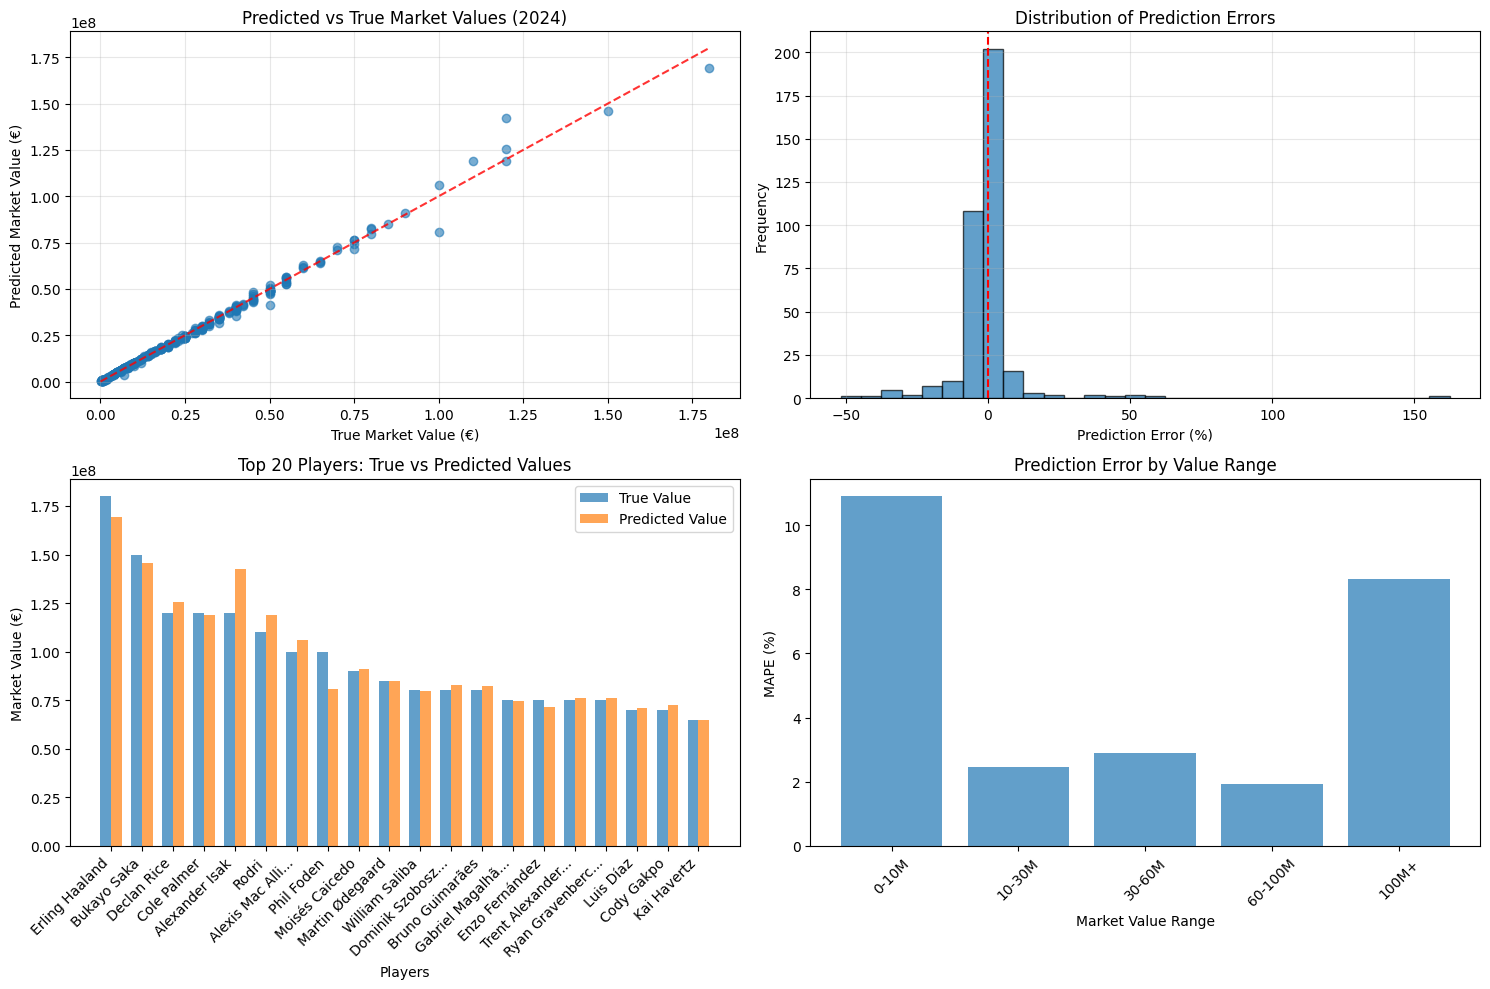

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_predictions(valid_predictions, year=2024):
    """
    绘制预测结果可视化
    """
    if not valid_predictions:
        print("没有有效数据用于可视化")
        return
    
    true_values = [v['true_value'] for v in valid_predictions.values()]
    pred_values = [v['predicted_value'] for v in valid_predictions.values()]
    player_names = list(valid_predictions.keys())
    
    plt.figure(figsize=(15, 10))
    
    # 子图1: 预测值 vs 真实值散点图
    plt.subplot(2, 2, 1)
    plt.scatter(true_values, pred_values, alpha=0.6)
    max_val = max(max(true_values), max(pred_values))
    plt.plot([0, max_val], [0, max_val], 'r--', alpha=0.8)
    plt.xlabel('True Market Value (€)')
    plt.ylabel('Predicted Market Value (€)')
    plt.title(f'Predicted vs True Market Values ({year})')
    plt.grid(True, alpha=0.3)
    
    # 子图2: 误差分布
    plt.subplot(2, 2, 2)
    errors = [(pred - true) / true * 100 for true, pred in zip(true_values, pred_values)]
    plt.hist(errors, bins=30, alpha=0.7, edgecolor='black')
    plt.xlabel('Prediction Error (%)')
    plt.ylabel('Frequency')
    plt.title('Distribution of Prediction Errors')
    plt.axvline(x=0, color='r', linestyle='--')
    plt.grid(True, alpha=0.3)
    
    # 子图3: 前20名球员对比
    plt.subplot(2, 2, 3)
    top_20_players = sorted(zip(player_names, true_values, pred_values), 
                           key=lambda x: x[1], reverse=True)[:20]
    top_names = [x[0] for x in top_20_players]
    top_true = [x[1] for x in top_20_players]
    top_pred = [x[2] for x in top_20_players]
    
    x = np.arange(len(top_names))
    width = 0.35
    
    plt.bar(x - width/2, top_true, width, label='True Value', alpha=0.7)
    plt.bar(x + width/2, top_pred, width, label='Predicted Value', alpha=0.7)
    plt.xlabel('Players')
    plt.ylabel('Market Value (€)')
    plt.title('Top 20 Players: True vs Predicted Values')
    plt.xticks(x, [name[:15] + '...' if len(name) > 15 else name for name in top_names], 
               rotation=45, ha='right')
    plt.legend()
    plt.tight_layout()
    
    # 子图4: 价值区间误差分析
    plt.subplot(2, 2, 4)
    value_ranges = ['0-10M', '10-30M', '30-60M', '60-100M', '100M+']
    range_mape = []
    
    for min_val, max_val, range_name in [(0, 10e6, '0-10M'), (10e6, 30e6, '10-30M'), 
                                        (30e6, 60e6, '30-60M'), (60e6, 100e6, '60-100M'),
                                        (100e6, float('inf'), '100M+')]:
        range_data = [(true, pred) for true, pred in zip(true_values, pred_values) 
                     if min_val <= true < max_val]
        if range_data:
            range_true, range_pred = zip(*range_data)
            range_mape.append(np.mean(np.abs((np.array(range_true) - np.array(range_pred)) / np.array(range_true))) * 100)
        else:
            range_mape.append(0)
    
    plt.bar(value_ranges, range_mape, alpha=0.7)
    plt.xlabel('Market Value Range')
    plt.ylabel('MAPE (%)')
    plt.title('Prediction Error by Value Range')
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.savefig(f'prediction_analysis_{year}.png', dpi=300, bbox_inches='tight')
    plt.show()

# 生成可视化
if 'valid_predictions' in locals() and valid_predictions:
    plot_predictions(valid_predictions, test_year)